In [1]:
from PIL import Image
from PIL import GifImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import os
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
file_dir="C:/Users/rhish/Downloads/archive/data"
file_list=os.listdir(file_dir)

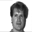

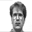

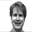

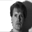

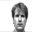

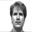

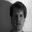

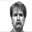

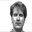

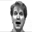

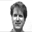

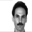

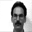

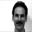

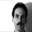

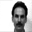

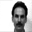

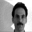

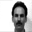

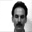

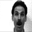

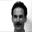

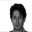

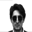

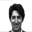

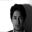

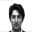

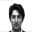

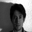

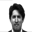

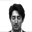

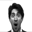

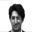

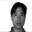

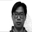

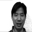

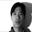

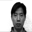

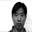

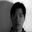

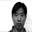

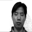

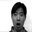

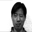

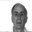

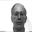

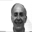

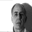

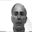

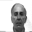

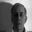

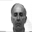

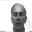

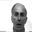

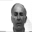

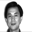

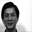

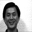

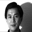

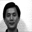

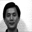

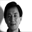

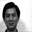

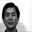

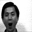

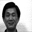

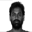

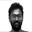

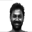

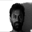

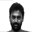

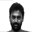

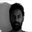

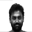

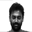

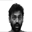

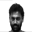

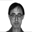

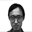

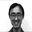

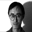

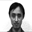

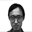

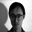

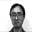

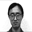

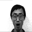

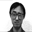

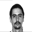

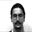

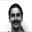

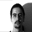

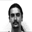

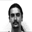

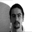

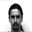

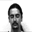

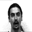

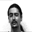

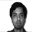

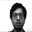

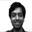

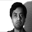

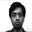

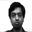

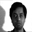

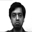

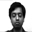

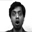

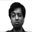

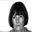

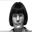

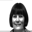

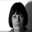

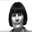

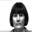

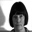

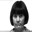

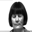

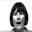

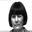

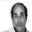

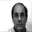

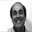

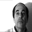

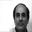

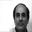

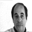

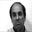

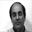

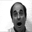

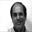

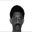

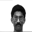

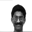

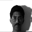

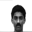

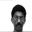

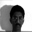

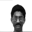

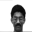

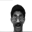

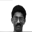

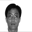

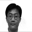

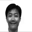

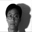

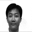

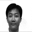

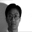

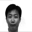

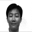

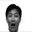

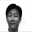

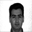

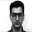

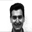

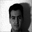

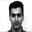

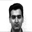

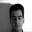

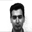

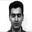

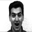

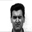

In [2]:
img=[]
for file in file_list:
    if(file=='Readme.txt'):
        continue
    else:
        path=os.path.join(file_dir,file)
        image=Image.open(path)
        image=image.resize((32,32))
        display(image)
        image=np.asarray(image)
        image=image.reshape(-1,)
        img.append(image)

In [3]:
#getting image dimensions as a vector
img[0].shape

(1024,)

In [4]:
labels=[x.split('.')[1] for x in file_list]
labels.remove('txt')
unique_labels=list(set(labels))
unique_labels

['centerlight',
 'normal',
 'surprised',
 'sleepy',
 'happy',
 'wink',
 'leftlight',
 'glasses',
 'rightlight',
 'sad',
 'noglasses']

In [5]:
len(labels)

165

In [6]:
img=np.array(img)
img.shape

(165, 1024)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import pandas as pd
#returns projection matrix
def preprocessing(img,method='PCA',plot=True):
    if(method=='PCA'):
        from sklearn.decomposition import PCA
        pca=PCA(n_components=min(len(img),img[0].shape[0]))
        new_img=pca.fit_transform(img)
        if(plot==True):
            plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
            plt.title("PCA: Plot to choose number of components")
            plt.xlabel('Number of components')
            plt.ylabel('Variance')
            plt.grid()
            plt.show()
        tol=99
        count=0
        for var in np.cumsum(pca.explained_variance_ratio_*100):
            count+=1
            if(var>=tol):
                break
        pca=PCA(n_components=count)
#         print('With tolerance (of variance, in percentage)=',tol,'\nNumber of components chosen for PCA:',count)
        new_img=pca.fit_transform(img)
    return new_img
#returns accuracy and time taken
def baseline(data,labels,tsize,seed):
    start=time.time()
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
    knn.fit(x_train,y_train)
    pred=knn.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return accuracy,time_taken
#returns accuracy and time taken
def LDA(data,labels,tsize,seed):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    start=time.time()
    data=preprocessing(data,'PCA',False)
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    lda=LinearDiscriminantAnalysis()
    new_img=lda.fit_transform(data,labels)
    pred=lda.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return new_img,accuracy,time_taken

In [8]:
def create_table(data,labels,model,choice):
    train_sizes=[10,20,30]
    table={}
    for size in train_sizes:
        accuracies=[]
        times=[]
        for i in range(20):
            new_data=data
            if(model is LDA):
                new_data,a, t=LDA(data,labels,size/len(data),i)
            if(choice=='LDA'):
                accuracies.append(a)
                times.append(t)
                continue
            else:
                a, t=baseline(new_data,labels,size/len(data),i)
                accuracies.append(a)
                times.append(t)
        a=sum(accuracies)/len(accuracies)
        t=str(round(sum(times)/len(times),3))+' ms'
        table[size]=[a,t]
    table=pd.DataFrame(table)
    table=table.rename(index={0:'Accuracy',1:'Time taken'})
    return table

In [9]:
create_table(img,labels,baseline,'base')

,10,20,30
Accuracy,0.145161,0.147931,0.162593
Time taken,5.819 ms,3.927 ms,5.478 ms


In [10]:
create_table(img,labels,LDA,'base')

,10,20,30
Accuracy,0.354194,0.462759,0.514815
Time taken,3.142 ms,3.559 ms,3.908 ms


In [11]:
create_table(img,labels,LDA,'LDA')

,10,20,30
Accuracy,0.789677,0.789655,0.787407
Time taken,31.192 ms,54.725 ms,78.618 ms


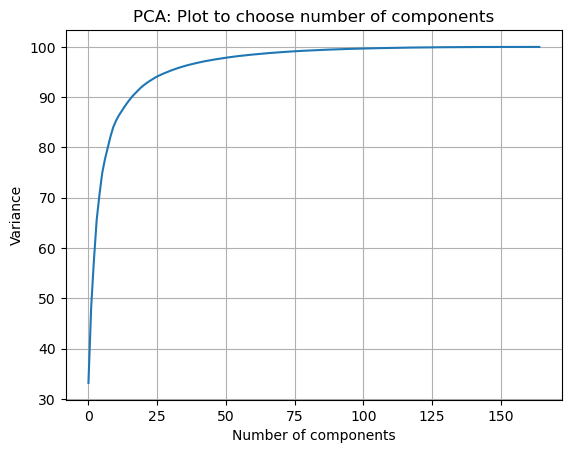

,10,20,30
Accuracy,0.144516,0.148621,0.163704
Time taken,10.679 ms,8.653 ms,9.539 ms


In [12]:
create_table(preprocessing(img),labels,baseline,'base')